In [17]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from matplotlib import pyplot as plt
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import StatevectorEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

In [18]:
def make_hydrogen_hamiltonian_and_uccsd(distance: float) -> (QuantumCircuit, QuantumCircuit):
    """
    Create a reduced 2-qubit Hamiltonian for a hydrogen molecule with given H-H distance.

    Args:
        distance (float): The distance between the two hydrogen atoms in angstroms.

    Returns:
        QuantumCircuit: The Hamiltonian as a quantum circuit.
    """
    driver = PySCFDriver(
        atom=f'H 0 0 0; H 0 0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        basis='sto3g',
    )
    problem = driver.run()
    mapper = JordanWignerMapper()
    # mapper = ParityMapper(num_particles=problem.num_particles)
    # theta1 = Parameter('θ1')
    # theta2 = Parameter('θ2')

    # ansatz = QuantumCircuit(2)
    # ansatz.ry(theta1, 0)
    # ansatz.ry(theta2, 1)
    # ansatz.cx(0, 1)
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    return (mapper.map(problem.hamiltonian.second_q_op()), ansatz)

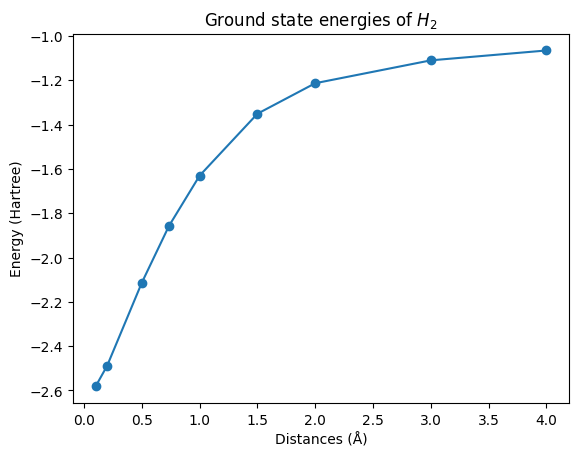

In [45]:
# SIMULATOR
optimizer = L_BFGS_B()
estimator = StatevectorEstimator()
distance_shots=[0.1, 0.2, 0.5, 0.735, 1.0, 1.5, 2.0, 3.0, 4.0]
convergences = []
nits=[]
# iterations_of_convergences = [[] for _ in range(len(distance_shots))]

for i in distance_shots:
    (qubit_hamiltonian, ansatz) = make_hydrogen_hamiltonian_and_uccsd(i)
    def estimate_energy(parameters):
        job = estimator.run(
            [(ansatz, qubit_hamiltonian, parameters)]
        )
        result = job.result()[0].data.evs
        # iterations_of_convergences[i].append(result)
        return result

    initial_point = np.zeros(ansatz.num_parameters)
    result = optimizer.minimize(fun=estimate_energy, x0=initial_point)
    nits.append(result.nit)
    convergences.append(result)

energies = [res.fun for res in convergences]
plt.plot(distance_shots, energies, marker='o', linestyle='-')
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $H_2$')
plt.show()

^^^ This is nonsense... at least for $< 1.5$ is nonsense...

In [20]:
def make_hydrogen_hamiltonian_hea(distance: float) -> (QuantumCircuit, QuantumCircuit):
    """
    Create a reduced 2-qubit Hamiltonian for a hydrogen molecule with given H-H distance.

    Args:
        distance (float): The distance between the two hydrogen atoms in angstroms.

    Returns:
        QuantumCircuit: The Hamiltonian as a quantum circuit.
    """
    driver = PySCFDriver(
        atom=f'H 0 0 0; H 0 0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        basis='sto3g',
    )
    problem = driver.run()
    mapper = ParityMapper(num_particles=problem.num_particles)
    theta1 = Parameter('θ1')
    theta2 = Parameter('θ2')

    ansatz = QuantumCircuit(2)
    ansatz.ry(theta1, 0)
    ansatz.ry(theta2, 1)
    ansatz.cx(0, 1)
    return (mapper.map(problem.hamiltonian.second_q_op()), ansatz)

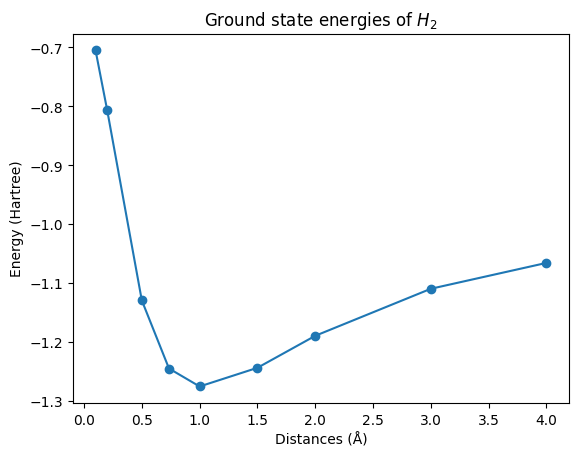

In [47]:
# SIMULATOR
optimizer = L_BFGS_B()
estimator = StatevectorEstimator()
distance_shots=[0.1, 0.2, 0.5, 0.735, 1.0, 1.5, 2.0, 3.0, 4.0]
convergences2 = []
# iterations_of_convergences = [[] for _ in range(len(distance_shots))]
nits2=[]

for i in distance_shots:
    (qubit_hamiltonian, ansatz) = make_hydrogen_hamiltonian_hea(i)
    def estimate_energy(parameters):
        job = estimator.run(
            [(ansatz, qubit_hamiltonian, parameters)]
        )
        result = job.result()[0].data.evs
        # iterations_of_convergences[i].append(result)
        return result

    initial_point = np.zeros(ansatz.num_parameters)
    result = optimizer.minimize(fun=estimate_energy, x0=initial_point)
    nits2.append(result.nit)
    convergences2.append(result)

energies = [res.fun for res in convergences2]
plt.plot(distance_shots, energies, marker='o', linestyle='-')
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $H_2$')
plt.show()

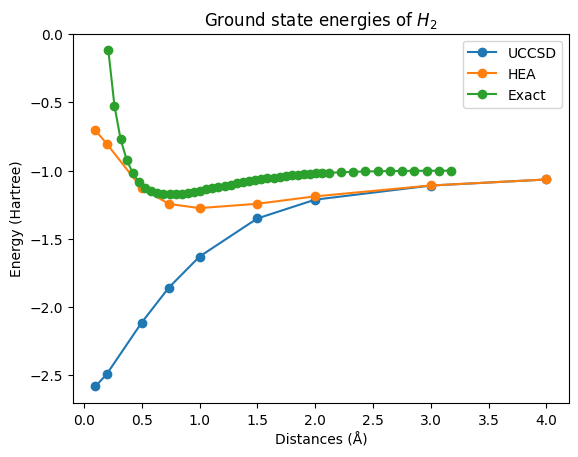

In [48]:

energies1 = [res.fun for res in convergences]
energies2 = [res.fun for res in convergences2]
# Exact from https://math.nist.gov/mcsd/savg/papers/h2.pdf
# Distances in bohr
bohr = [
    0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,
    1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3,
    2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3,
    3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.2, 4.4, 4.6,
    4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0
]

# Convert to Å
angstroms = [round(x * 0.529177, 6) for x in bohr]

# Energies in hartree
energies = [
    -0.1202303411778644, -0.5266387587423172, -0.7696354294853568, -0.9220274615270152,
    -1.0200566663601389, -1.0836432399585087, -1.1245397195465791, -1.1500573677382885,
    -1.1649352434400281, -1.1723471490377800, -1.1744757142200755, -1.1728550795781447,
    -1.1685833733709263, -1.1624587268978088, -1.1550687376108071, -1.1468506970287210,
    -1.1381329571315035, -1.1291638360999721, -1.1201321168476391, -1.1111817652026448,
    -1.1024226060092978, -1.0939381299535998, -1.0857912373935887, -1.0780284841810479,
    -1.0706832334784095, -1.0637780088027916, -1.0573262688692439, -1.0513337722644516,
    -1.0457996614287338, -1.0407173653475985, -1.0360753951869195, -1.0318580848512230,
    -1.0280463083758766, -1.0246181884071472, -1.0215497955299109, -1.0188158276928498,
    -1.0163902529471283, -1.0123595966799189, -1.0092565162586632, -1.0068952238201211,
    -1.0051160060980952, -1.0037856585819889, -1.0027968163095431, -1.0020650572082353,
    -1.0015252518853549, -1.0011278808513214, -1.0008357076542279
]

plt.plot(distance_shots, energies1, marker='o', linestyle='-')
plt.plot(distance_shots, energies2, marker='o', linestyle='-')
plt.plot(angstroms, energies, marker='o', linestyle='-')
plt.legend(['UCCSD', 'HEA', 'Exact'])
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $H_2$')
plt.show()

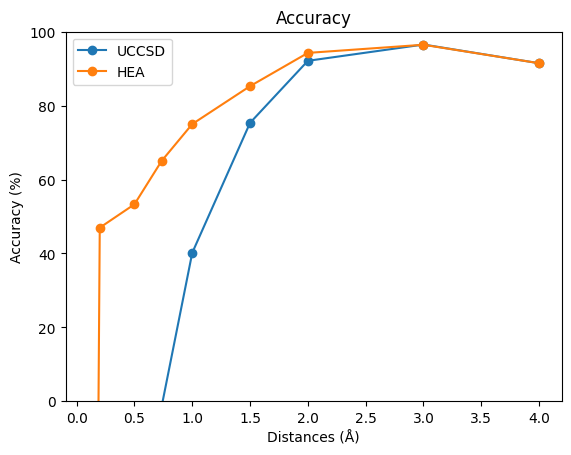

In [ ]:
# accuracy
def accuracy(energy, exact_energy):
    return 100 - abs((energy - exact_energy) / exact_energy) * 100 # MAPE(mean abs perc error), gal ir kiti literaturoje accuracy matavimui. palhyginti su literaturoje matavimais.
def get_accuracies(energies, exact_energies):
    accuracies = []
    for i in range(len(energies)):
        accuracies.append(accuracy(energies[i], exact_energies[i]))
    return accuracies
accuracies1 = get_accuracies(energies1, energies)
accuracies2 = get_accuracies(energies2, energies)
plt.plot(distance_shots, accuracies1, marker='o', linestyle='-')
plt.plot(distance_shots, accuracies2, marker='o', linestyle='-')
plt.legend(['UCCSD', 'HEA'])
plt.ylim(0, 100)
plt.xlabel('Distances (Å)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.show()

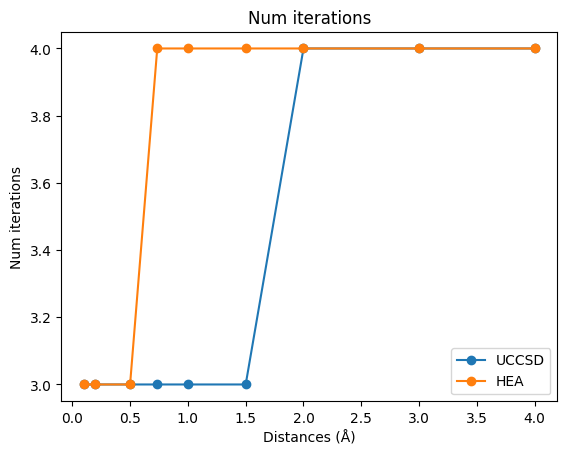

In [50]:
# num iterations
plt.plot(distance_shots, nits, marker='o', linestyle='-')
plt.plot(distance_shots, nits2, marker='o', linestyle='-')
plt.legend(['UCCSD', 'HEA'])
plt.xlabel('Distances (Å)')
plt.ylabel('Num iterations')
plt.title('Num iterations')
plt.show()

Default gradient toleration for BFGS optimiser is 10^-5

# Now metrics for 0.735A case

## UCCSD 

In [43]:
(qubit_hamiltonian1, ansatz1) = make_hydrogen_hamiltonian_and_uccsd(i)
print("Number of qubits:", qubit_hamiltonian1.num_qubits)
print("Number of parameters:", ansatz1.num_parameters)
print("Depth:", ansatz1.depth())


Number of qubits: 4
Number of parameters: 3
Depth: 1


## HEA

In [41]:
(qubit_hamiltonian2, ansatz2) = make_hydrogen_hamiltonian_hea(i)
print("Number of qubits:", qubit_hamiltonian2.num_qubits)
print("Number of parameters:", ansatz2.num_parameters)
print("Depth:", ansatz2.depth())

Number of qubits: 2
Number of parameters: 2
Depth: 2
